# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otocznia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3.Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

In [56]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
import math

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/'

fileNames = ["MR_data.mat"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)

#TODO Samodzielna

def show_all(images = [], vertical = False):
    def append_plot(ax, image):
        ax.imshow(image, 'gray')

    n = len(images)
    shorter_side = 10
    longer_side = 5 * len(images)

    if vertical:
        fig, axs = plt.subplots( n, 1 )
        fig.set_size_inches(shorter_side, longer_side)
    else:
        fig, axs = plt.subplots( 1, n )
        fig.set_size_inches(longer_side, shorter_side)


    if len(images) == 1:
        image = images[0]
        append_plot(axs, image)
    else:
        for i in range(len(images)):
            image = images[i]
            append_plot(axs[i], image)
    plt.show()

def open_image(path, gray = True):
    image = loadmat(path)
    # image = cv2.imread(path)

    # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY if gray else cv2.COLOR_BGR2RGB)
    return image

image_mr = open_image(fileNames[0])

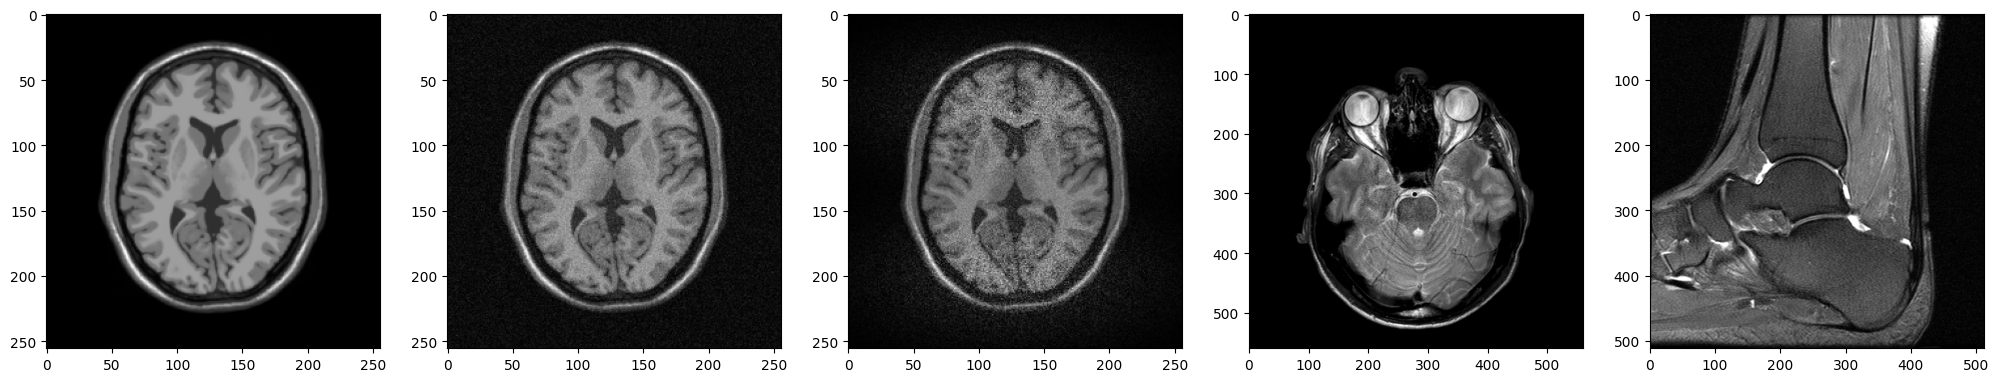

In [57]:
show_all([
    image_mr['I_noisefree'],
    image_mr['I_noisy1'],
    image_mr['I_noisy2'],
    image_mr['I_noisy3'],
    image_mr['I_noisy4']
])

### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

In [58]:
def use_filter(image, kernel):
    return cv2.filter2D(src=image, ddepth=-1, kernel=kernel)

# Complete method from lab6
def fgaussian(size, sigma):
    m = n = size
    h, k = m//2, n//2
    x, y = np.mgrid[-h:h+1, -k:k+1]
    g = np.exp(-(x**2 + y**2)/(2*sigma**2))
    return g /g.sum() 

def mesh(fun, size):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    X = np.arange(-size//2, size//2, 1)
    Y = np.arange(-size//2, size//2, 1)
    X, Y = np.meshgrid(X, Y)
    Z = fun
    
    ax.plot_surface(X, Y, Z)
    
    plt.show()


def plot_mesh(size, sigma):
    mask = fgaussian(size, sigma)
    mesh(mask, size)

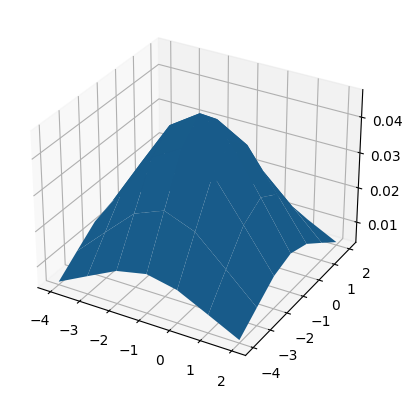

In [70]:
window_size = 7
variance = 2

plot_mesh(window_size, variance)

In [60]:
def use_convolution(window, mask):
    wn = 1 / mask.sum()
    return wn * np.sum(window * mask)

def classic_convolution(image, window_size, variance):
    mask = fgaussian(window_size, variance)
    image_copy = image.copy()
    border = window_size // 2
    
    for row in range(border, image.shape[0] - border):
        for col in range(border, image.shape[1] - border):
            window = image[
                row - border: row + border + 1, 
                col - border: col + border + 1
            ]
    
            image_copy[row, col] = use_convolution(window, mask)

    return image_copy



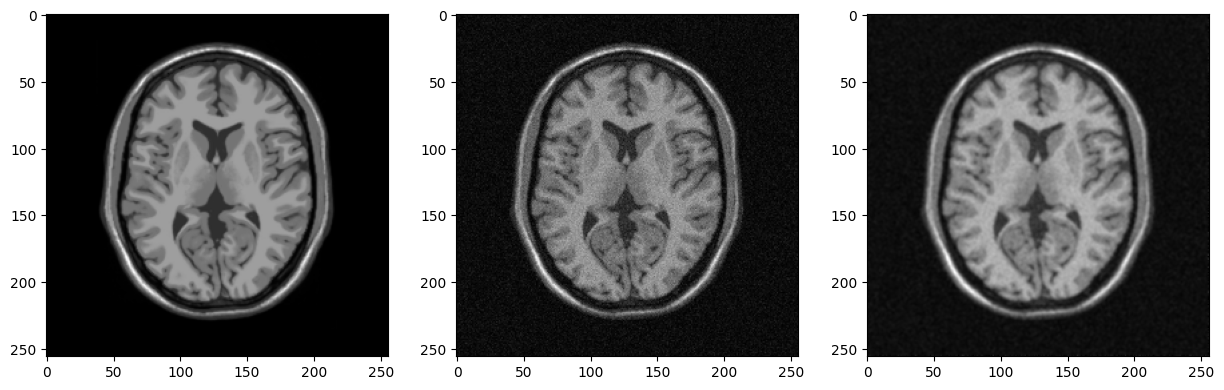

In [73]:
show_all([
    image_mr['I_noisefree'],
    image_mr['I_noisy1'],
    classic_convolution(image_mr['I_noisy1'], 3, .9)
])

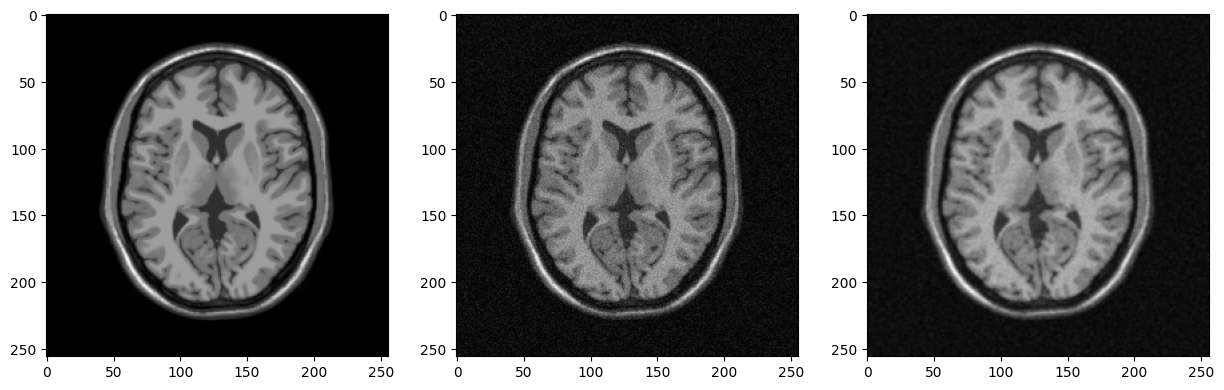

In [74]:
show_all([
    image_mr['I_noisefree'],
    image_mr['I_noisy1'],
    classic_convolution(image_mr['I_noisy1'], 3, .7)
])

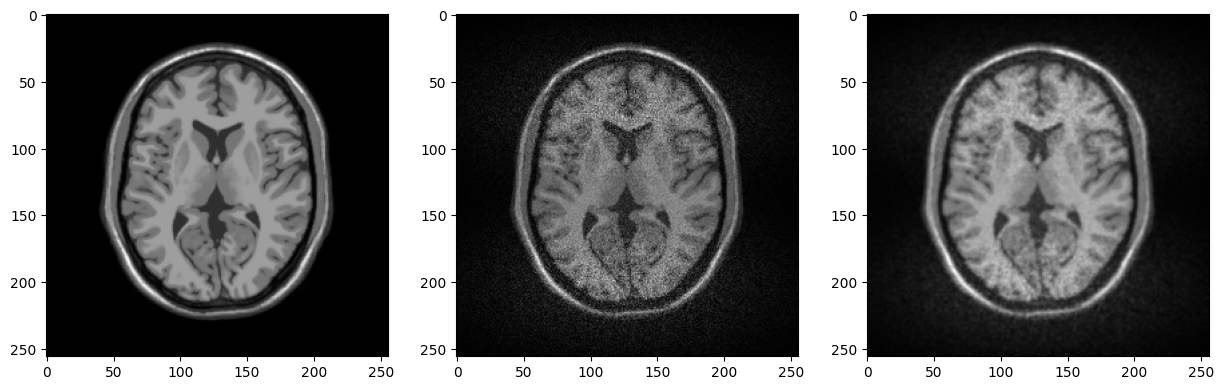

In [79]:
show_all([
    image_mr['I_noisefree'],
    image_mr['I_noisy2'],
    classic_convolution(image_mr['I_noisy2'], 7, .8)
])

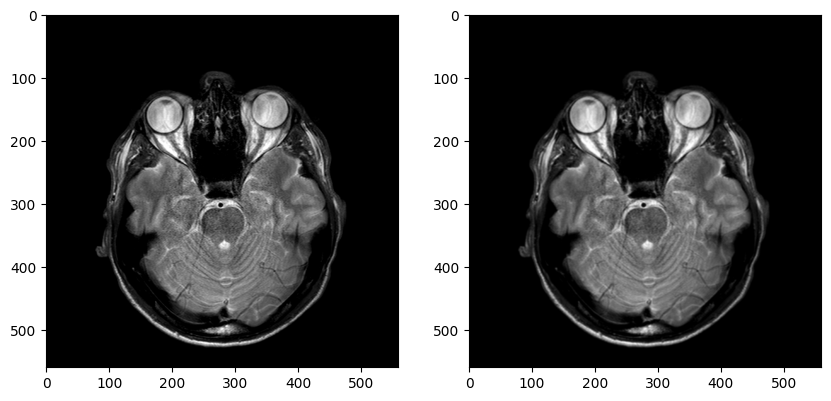

In [80]:
show_all([
    image_mr['I_noisy3'],
    classic_convolution(image_mr['I_noisy3'], 3, .7)
])

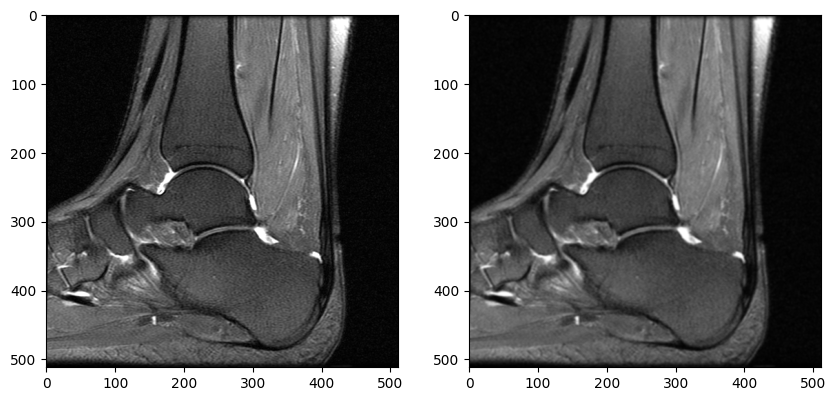

In [65]:
show_all([
    image_mr['I_noisy4'],
    classic_convolution(image_mr['I_noisy4'], 5, 1)
])

### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gausowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

In [66]:
def gamma(y, variance_r):
    return np.exp(- (y ** 2) / (2 * variance_r ** 2))

def use_bilateral_convolution(
    window, 
    mask, 
    variance_r
):
    window_center = window.shape[0] // 2 + 1
    psi = mask * gamma(np.abs(window - window[window_center, window_center]), variance_r)
    wn = psi.sum()
    return 1 / wn * np.sum(psi * window)

def bilateral_filtration(image, window_size, variance, variance_r):
    mask = fgaussian(window_size, variance)
    image_copy = image.copy()
    border = window_size // 2
    
    for row in range(border, image.shape[0] - border):
        for col in range(border, image.shape[1] - border):
            window = image[
                row - border: row + border + 1, 
                col - border: col + border + 1
            ]
    
            image_copy[row, col] = use_bilateral_convolution(window, mask, variance_r)

    return image_copy


def compare_results(image, window_size, variance, variance_r):
    image_filtered = bilateral_filtration(image, window_size, variance, variance_r)
    return [image, image_filtered, image - image_filtered]

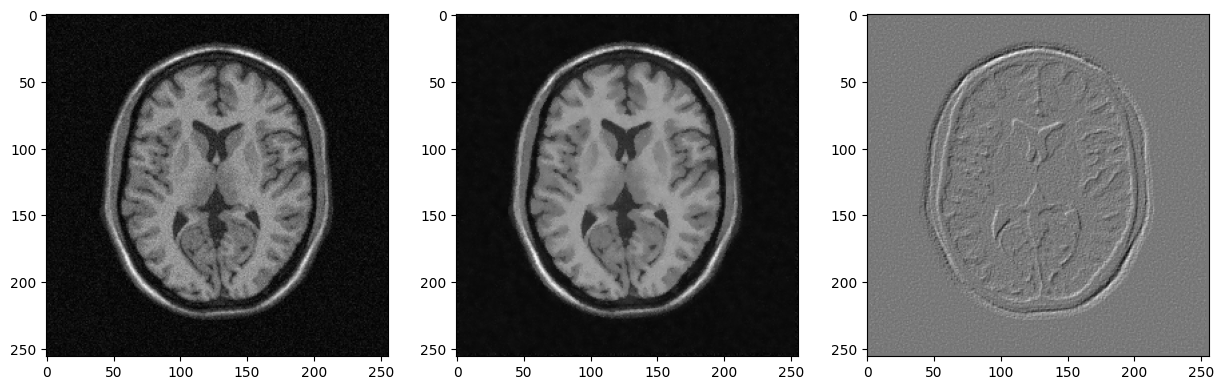

In [85]:
noisy1_window_size = 5
noisy1_variance = 3
noisy1_variance_r = 15

show_all(compare_results(image_mr['I_noisy1'], noisy1_window_size, noisy1_variance, noisy1_variance_r))

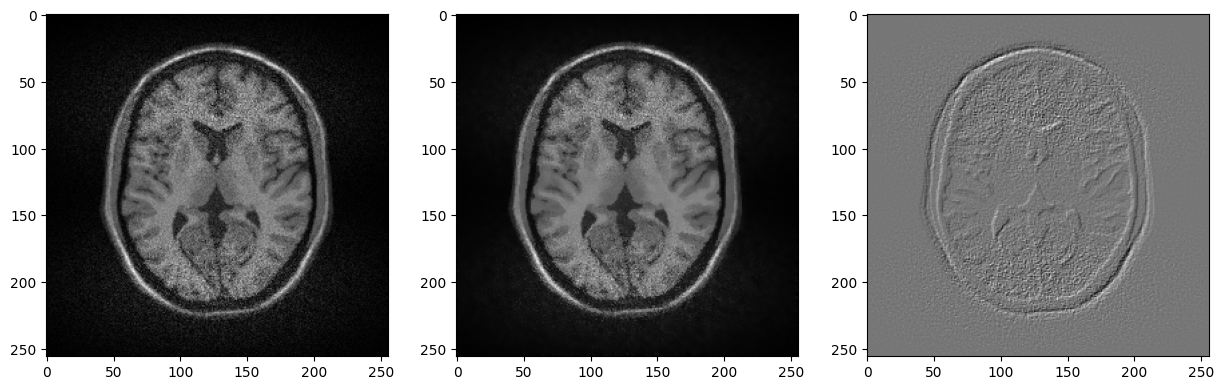

In [86]:
noisy1_window_size = 5
noisy1_variance = 3
noisy1_variance_r = 15

show_all(compare_results(image_mr['I_noisy2'], noisy1_window_size, noisy1_variance, noisy1_variance_r))